# 创建预测材料表, 加载模型, 预测

In [2]:
import os
import numpy as np
import pandas as pd
import re
import time
import itertools
from joblib import load
from concurrent.futures import ThreadPoolExecutor
from datetime import datetime

# 配置文件路径和日志文件名
CONFIG = {
    'model_path': '../1_Tree_model_train/2-model/ET.joblib',
    'feature_names_path': '../1_Tree_model_train/2-model/ET_feature.joblib',
    'output_dir': './Alloy/',
    'log_file': f'./Alloy/alloy_log_{datetime.now().strftime("%m%d%H%M")}.txt',
}

# 确保输出目录存在
os.makedirs(CONFIG['output_dir'], exist_ok=True)

# 加载模型和特征名称
model = load(CONFIG['model_path'])
feature_names = load(CONFIG['feature_names_path'])

# 定义预测函数
def predict_transition_temp(model, feature_names, elements_ratios):
    feature_row = {element: elements_ratios.get(element, 0) for element in feature_names}
    input_features = pd.DataFrame([feature_row], columns=feature_names)
    predicted_temp = model.predict(input_features)
    return predicted_temp[0]

# 生成随机化学式
def generate_formulas(elements, num_formulas):
    formulas = []
    while len(formulas) < num_formulas:
        coefficients = np.random.rand(len(elements))
        coefficients /= coefficients.sum()
        coefficients = np.round(coefficients, 3)
        if np.all(coefficients >= 0) and np.isclose(coefficients.sum(), 1):
            formula = ''.join(f"{elements[i]}{coefficients[i]:.3f}" for i in range(len(elements)) if coefficients[i] != 0)
            formulas.append(formula)
    return formulas

# 化学式拆分为字典
def parse_formula(formula):
    formula = str(formula)  # 确保formula是字符串
    elements_ratios = {}
    for element, ratio in re.findall(r'([A-Z][a-z]*)(\d*\.?\d*)', formula):
        if element in elements_ratios:
            elements_ratios[element] += float(ratio) if ratio else 1
        else:
            elements_ratios[element] = float(ratio) if ratio else 1
    return elements_ratios

# 将消息写入日志文件
def log_message(message):
    with open(CONFIG['log_file'], "a") as log_file:
        log_file.write(message + "\n")

# 主函数，执行预测
def main(elements, num_formulas):
    file_name = '-'.join(elements)
    file_path = os.path.join(CONFIG['output_dir'], f'{file_name}.csv')
    formulas = generate_formulas(elements, num_formulas)
    df = pd.DataFrame(formulas, columns=['formula'])

    with ThreadPoolExecutor() as executor:
        results = list(executor.map(lambda x: predict_transition_temp(model, feature_names, parse_formula(x)), df['formula']))

    df['Predicted_Tc'] = results
    df.to_csv(file_path, index=False)

if __name__ == "__main__":
    start_time = time.time()
    elements = ['Ga', 'In' ,'Sn']
    num_elements = 3

    for r in range(3, num_elements + 1):
        for elements_combination in itertools.combinations(elements, r):
            alloy_time = time.time()
            num_formulas = 1 if r == 1 else 10000
            main(elements_combination, num_formulas)
            cycle_time = time.time() - alloy_time
            log_message(f"Finished predicting for alloy: {elements_combination};{cycle_time:.2f} seconds")

    elapsed_time = time.time() - start_time
    log_message(f"\nElapsed time: {elapsed_time:.2f} seconds")

# 画出预测数据

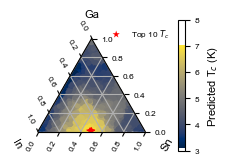

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import mpltern  # 导入mpltern库

# 设置matplotlib配置，确保可以显示中文和负号
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.family'] = 'Arial'  # 例如，设置为 Arial 字体

file_path = './Alloy/Ga-In-Sn_RF.csv'  # 文件路径

# 加载数据
data = pd.read_csv(file_path)  # 文件读取

# 提取Ga, In, Sn的含量和对应的Tc
ga = data['formula'].str.extract(r'Ga(\d+\.\d+)').astype(float).values.flatten()
in_ = data['formula'].str.extract(r'In(\d+\.\d+)').astype(float).values.flatten()
sn = data['formula'].str.extract(r'Sn(\d+\.\d+)').astype(float).values.flatten()
tc = data['Predicted_Tc'].values

fig_height = 6.3  # cm
fig_width = 6  # cm

# 初始化绘图
fig = plt.figure(figsize=(fig_width/2.54, fig_height/2.54))
ax = fig.add_subplot(projection='ternary')

# 绘制三元图
scatter = ax.scatter(ga, in_, sn, c=tc, cmap='cividis', marker='o', alpha=1, s=15, edgecolor='none')

top_idx = np.argsort(-tc)[:10]
# 突出显示Tc值最大的十个点，使用更大的大小和不同的标记
top_points = ax.scatter(ga[top_idx], in_[top_idx], sn[top_idx], 
                        c='red', marker='*', s=30, label='Top 10 $T_c$',edgecolor='none')

# 添加图例，调整位置和大小
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.2), fontsize='6', framealpha=0)

# 设置轴标签
ax.set_tlabel('Ga', fontsize=8, color='black',labelpad=-0.1)
ax.set_llabel('In', fontsize=8, color='black',labelpad=-0.1)
ax.set_rlabel('Sn', fontsize=8, color='black',labelpad=-0.1)
ax.tick_params(axis='both', which='major', labelsize=6)  # 增大刻度标签字体大小

# 添加颜色条，调整位置和尺寸
cbar = fig.colorbar(scatter, ax=ax, pad=0.2, shrink=0.6)
cbar.set_label('Predicted T$_c$ (K)', fontsize='8')
cbar.set_ticks(np.arange(3, 9, 1))
cbar.ax.tick_params(axis='both', which='major', labelsize=6)

# 添加网格线
ax.grid(True)

plt.tight_layout()
plt.savefig('../../Pic/Pic/Fig4d_1_4a.tif', dpi=300, bbox_inches='tight', transparent=True)
plt.savefig('../../Pic/Pic/Fig4d_1_4a.svg',  bbox_inches='tight', transparent=True)
plt.show()